#  Data Analysis: Moral Foundations Theory
---
<img src="https://c1.staticflickr.com/7/6240/6261650491_0cd6c701bb_b.jpg" style="width: 500px; height: 275px;" />

### Professor Amy Tick

Moral Foundations Theory (MFT) hypothesizes that people's sensitivity to the foundations is different based on their political ideology: liberals are more sensitive to care and fairness, while conservatives are equally sensitive to all five. Here, we'll explore whether we can find evidence for MFT in the campaign speeches of 2016 United States presidential candidates. For our main analysis, we'll go through the data science process start to finish to recreate a simplified version of the analysis done by Jesse Graham, Jonathan Haidt, and Brian A. Nosek in their 2009 paper ["Liberals and Conservatives Rely on Different Sets of Moral Foundations"](http://projectimplicit.net/nosek/papers/GHN2009.pdf). Finally, we'll explore other ways to visualize and use this data in rhetorical analysis.

*Estimated Time: 50 minutes*

---

### Topics Covered
- Word count using a dictionary
- Data visualization with pandas
- Graph interpretations

<!-- 

### Table of Contents


1 - [Data Set and Test Statistic]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 - [2016 Campaign Speeches]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 - [Moral Foundations Dictionary]

2 - [Data Analysis]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 - [Calculating Perceptages]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 - [Filtering Table Rows]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 - [Democrats]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 - [Republicans]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.5 - [Democrats vs Republicans]

3 - [Additional Visualizations]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1 - [Dinosaur Data]

4 - [Dictionary Comparisons]

-->

**Dependencies:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
from nltk.stem.snowball import SnowballStemmer
import os
import re
from ast import literal_eval

# Part 0: Creating Your Dictionary

In [2]:
# Make 6 lists. 
# Tip: each word needs to go in quotation marks and each string must be separated by commas
care_words = []
authority_words = []
loyalty_words = []
sanctity_words = []
fairness_words = []
liberty_words = []

This following cell will now take in the lists we just created, and combine them into one dictionary that we can use for our analysis.

In [25]:
my_dict = {'care_words': care_words,
           'authority_words': authority_words,
           'loyalty_words': loyalty_words,
           'sanctity_words': sanctity_words,
           'fairness_words': fairness_words,
           'liberty_words' : liberty_words}

Run this next cell to see what the dictionary looks like.

In [26]:
my_dict

{'authority_words': [],
 'care_words': [],
 'fairness_words': [],
 'liberty_words': [],
 'loyalty_words': [],
 'sanctity_words': []}

FInally, run this next cell to make your dictionary into a file.

In [27]:
# Run this cell to write dictionary to a file
import json 
# convert dictionary to a JSON-formatted string
with open('../mft_data/my_dict.json', 'w') as fp:
    json.dump(my_dict, fp, sort_keys=True, indent=4)

---
## Intro: The Data Science Process

On Friday, we defined data science as an interdisciplinary field, combining statistics, computer science, and domain expertise to understand the world and solve problems. The data science process can be thought of like this:

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Data_visualization_process_v1.png" style="width: 550px; height: 400px;" />

This module walks through a simplified version of the process to explore speech data and probe Moral Foundations Theory. Steps done in this module are in bold.

1. Raw Data Collection: speech data is collected into csv files via web-scraping.
2. **Data Processing/Cleaning**: speech data is transformed to enable analysis. Some processing/cleaning has already been done.
3. **Exploratory Data Analysis**: transform, visualize, and summarize data with the goal of understanding the data set, finding possible issues, and looking for potential questions to explore further.
4. **Models and Algorithms**: develop and test a *model*- a theory of how the data was generated (in this case, Moral Foundations Theory).
5. Communicate, Visualize, Report: to be discussed in Day 03.

---
## Part 1: Speech Data and Foundations Dictionary  <a id='section 1'></a>

In Part 1, we'll get familiar with our data set and determine a way to answer questions using the data.

### 2016 Campaign Speeches <a id='subsection 1'></a>

Run the cell below to load the data.


In [28]:
# load the cleaned data from csv files into a table and make sure columns are of the right type after importing 
speeches = pd.read_csv("speeches_clean.csv", index_col=0)
clean_speeches = pd.read_csv("speeches_clean.csv", index_col=0)
speeches["clean_speech"] = speeches["clean_speech"].apply(literal_eval)

# show the first 5 rows of the table
speeches.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech
0,Jeb Bush,R,c,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,..."
1,Jeb Bush,R,c,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y..."
2,Jeb Bush,R,c,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ..."
3,Jeb Bush,R,c,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ..."
4,Jeb Bush,R,c,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ..."


With using the Moral Foundations Theory, we want to evaluate how politicians talk to those who agree with them. Therefore, it is the most helpful to see statements that candidates make to their own party members rather than the nation. In order to account for this, in the following code chunk we filter out any titles that contain the word "press", "interview", and "debate", since press statements and general election debates or interviews are less useful to our analysis.

In [29]:
# filter the date
speeches["Date"] = pd.to_datetime(speeches["Date"])
# speeches = speeches[(speeches["Date"].dt.month < 6) | (speeches["Date"].dt.year % 4 != 0)]

# filter out less meaningflul content from the data set
speeches = speeches[~speeches["Title"].str.lower().str.contains("press")]
speeches = speeches[~speeches["Title"].str.lower().str.contains("interview")]
speeches = speeches[~speeches["Title"].str.lower().str.contains("debate")]


speeches.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech
0,Jeb Bush,R,c,2015-06-15,Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,..."
1,Jeb Bush,R,c,2015-07-30,Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y..."
2,Jeb Bush,R,c,2015-08-11,Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ..."
3,Jeb Bush,R,c,2015-09-09,"Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ..."
4,Jeb Bush,R,c,2015-11-02,"Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ..."


Take a moment to look at this table. Before doing any analysis, it's important to understand:
* the size of the table (how much data does it contain?)
* the structure of the table (how is the data organized?)
* what information it contains (what are the aspects of each record described in columns? what does each record (row) represent?)

Look over each column in the table and write a few words describing how we may use this in our analysis later on.

WRITE HERE

### Moral Foundations Dictionary <a id='subsection 2'></a>

In ["Liberals and Conservatives Rely on Different Sets of Moral Foundations"](http://projectimplicit.net/nosek/papers/GHN2009.pdf), one of the methods Graham, Haidt, and Nosek use to measure people's use of Moral Foundations Theory is to count how often they use words related to each foundation. This will be our test statistic for today. To calculate it, we'll need a dictionary of words related to each moral foundation. 

Now we will get to use the dictionaries that you have created. We saved this dictionary as a json file which we will now open and use for our analysis.

There is another dictionary we'll use today that comes from a database called [WordNet](https://wordnet.princeton.edu), in which "nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept." By querying WordNet for semantically related words, it was possible to build a dictionary automatically using a Python program.



In [30]:
# Load a dictionary into the mft_dict variable
# The path is the argument for the open function. It gives the location of the dictionary file.
with open('../mft_data/my_dict.json') as json_data:
    mft_dict = json.load(json_data)

# Stem the words in your dictionary (this will help you get more matches)
stemmer = SnowballStemmer('english')

for foundation in mft_dict.keys():
    curr_words = mft_dict[foundation]
    stemmed_words = [stemmer.stem(word) for word in curr_words]
    mft_dict[foundation] = stemmed_words
    
keys = mft_dict.keys()
list(keys)

['authority_words',
 'care_words',
 'fairness_words',
 'liberty_words',
 'loyalty_words',
 'sanctity_words']

---
## Part 2: Exploratory Data Analysis <a id='section 2'></a>

Now that we have our speech data and our dictionary, we can start our exploratory analysis. The exploratory analysis in this module will be more focused than in most cases since we already have a model in mind- Moral Foundations Theory.

To get a sense of how Moral Foundations words were used in campaign speeches, we'll do three things:
1. Count the occurances of words from our dictionary in each speech
2. Calculate how often words from each category are used by each political party
3. Plot the percents on a bar graph

Think about what you know about Moral Foundations Theory. If this data is consistent with the theory, what should our analysis show for Republican candidates? What about for Democratic candidates? Try sketching a possible graph for each political party, assuming that candidates' speech aligns with the theory.

### Calculating Percentages <a id='subsection 3'></a>

We're interesting in knowing the percent of words that correspond to a Moral Foundation in speeches- in other words, how often candidates use words related to a specific foundation. 

(Bonus question: why don't we just use the **number** of Moral Foundation words instead of the **percent** as our test statistic?)

To calculate the percent, we'll first need the total number of words in each speech.

In [31]:
# create a new column called 'total_words'
speeches['total_words'] = [len(speech) for speech in speeches['clean_speech']]
speeches.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words
0,Jeb Bush,R,c,2015-06-15,Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,...",2284
1,Jeb Bush,R,c,2015-07-30,Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y...",2638
2,Jeb Bush,R,c,2015-08-11,Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ...",3735
3,Jeb Bush,R,c,2015-09-09,"Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ...",1880
4,Jeb Bush,R,c,2015-11-02,"Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ...",2550


Next, we need to calculate the number of matches to entries in our dictionary for each foundation for each speech. 

Run the next cell to add six new columns to `speeches`, one per foundation, that show the number of word matches.

In [32]:
#Note: much of the following code is not covered in these modules. Read the comments to get a sense of what it does.

# do the following code for each foundation
for foundation in mft_dict.keys():
    # create a new, empty column
    num_match_words = np.zeros(len(speeches))
    stems = mft_dict[foundation]
    
    # do the following code for each foundation word
    for stem in stems:
        # find synonym matches
        wd_count = np.array([sum([wd.startswith(stem) for wd in speech]) for speech in speeches['clean_speech']])
        # add the number of matches to the total
        num_match_words += wd_count
        
    # create a new column for each foundation with the number of foundation words per speech
    speeches[foundation] = num_match_words

speeches.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words,authority_words,care_words,fairness_words,liberty_words,loyalty_words,sanctity_words
0,Jeb Bush,R,c,2015-06-15,Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,...",2284,0.0,0.0,0.0,0.0,0.0,0.0
1,Jeb Bush,R,c,2015-07-30,Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y...",2638,0.0,0.0,0.0,0.0,0.0,0.0
2,Jeb Bush,R,c,2015-08-11,Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ...",3735,0.0,0.0,0.0,0.0,0.0,0.0
3,Jeb Bush,R,c,2015-09-09,"Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ...",1880,0.0,0.0,0.0,0.0,0.0,0.0
4,Jeb Bush,R,c,2015-11-02,"Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ...",2550,0.0,0.0,0.0,0.0,0.0,0.0


To calculate the percentage of foundation words per speech, divide the number of matched words by the number of total words and multiply by 100.

In [33]:
for foundation in mft_dict.keys():
    speeches[foundation] = (speeches[foundation] / speeches['total_words']) * 100

speeches.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words,authority_words,care_words,fairness_words,liberty_words,loyalty_words,sanctity_words
0,Jeb Bush,R,c,2015-06-15,Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,...",2284,0.0,0.0,0.0,0.0,0.0,0.0
1,Jeb Bush,R,c,2015-07-30,Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y...",2638,0.0,0.0,0.0,0.0,0.0,0.0
2,Jeb Bush,R,c,2015-08-11,Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ...",3735,0.0,0.0,0.0,0.0,0.0,0.0
3,Jeb Bush,R,c,2015-09-09,"Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ...",1880,0.0,0.0,0.0,0.0,0.0,0.0
4,Jeb Bush,R,c,2015-11-02,"Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ...",2550,0.0,0.0,0.0,0.0,0.0,0.0


Stop and take a moment to look over the chart above. What do our new columns (authority/subversion, etc) represent? Write a short description of how to interpret these columns.

WRITE ANSWER HERE

### Filtering table rows <a id='subsection 4'></a>

To examine the data for a particular political party, it is necessary to filter out rows of our table that correspond to speeches from the other party, something we can do with **Boolean indexing**.

A **Boolean** is a Python data type. There are exactly two: `True` and `False`. A Boolean expression is an expression that evaluates to `True` or `False`. Boolean expressions are often conditions on two variables; that is, they ask how one variable compares to another (e.g. is `a` greater than `b`? Does `a` equal `c`?).

In [34]:
# These are all Booleans
True

not False

6 > 0

"Donald Trump" == "Ted Cruz"

False

Note that Python uses `==` to check if two things are equal. This is because the `=` sign is already used for variable assignment.

Filtering out DataFrame rows can be broken into three steps:
1. identify the correct feature column 
2. specify the desired condition for that column
3. index the Dataframe with that condition in square brackets


### Democrats <a id='subsection 5'></a>

Let's start by looking at Democratic candidates. First, we need to make a table that only contains Democrats using boolean indexing.

In [35]:
# Filter out non-Democrat speeches
party_col = speeches['Party']

dem_cond = party_col == 'D'

democrats = speeches[dem_cond]

democrats.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words,authority_words,care_words,fairness_words,liberty_words,loyalty_words,sanctity_words
436,Lincoln Chafee,D,c,2015-06-03,Remarks Announcing Candidacy for President at ...,"Thank you, Bob. Thank you, Bob and Mark, very ...","[thank, you, bob, thank, you, bob, and, mark, ...",5512,0.0,0.0,0.0,0.0,0.0,0.0
437,Lincoln Chafee,D,c,2015-07-17,Remarks at the Iowa Democrats Hall of Fame Din...,Congratulations to the Hall of Fame Inductees....,"[congratulations, to, the, hall, of, fame, ind...",745,0.0,0.0,0.0,0.0,0.0,0.0
438,Lincoln Chafee,D,c,2015-10-23,Remarks Announcing the End of Presidential Cam...,Once again it is a pleasure to join so many De...,"[once, again, it, is, a, pleasure, to, join, s...",939,0.0,0.0,0.0,0.0,0.0,0.0
570,Hillary Clinton,D,c,2007-01-20,Video Transcript: Presidential Exploratory Com...,HILLARY CLINTON: I announced today that I am f...,"[hillary, clinton, i, announced, today, that, ...",349,0.0,0.0,0.0,0.0,0.0,0.0
571,Hillary Clinton,D,c,2007-01-22,"Remarks in a ""Let the Conversation Begin Webcast""","SENATOR CLINTON: Hi, everyone, and welcome to ...","[senator, clinton, hi, everyone, and, welcome,...",5349,0.0,0.0,0.0,0.0,0.0,0.0


We have our percentages for the Democratic party, but it's much easier to understand what's going on when the results are in graph form. Let's start by looking at the average percents for Democrats as a group. 


In [36]:
# select the foundations columns and calculate the mean percent for each
avg_dem_stats = (democrats.loc[:, list(mft_dict.keys())]
                 .apply(np.mean)
                 .to_frame('D_percent'))

avg_dem_stats

,D_percent
authority_words,0.0
care_words,0.0
fairness_words,0.0
liberty_words,0.0
loyalty_words,0.0
sanctity_words,0.0


Now, create a horizontal bar plot by calling the `.plot.barh()` method on `avg_dem_stats`. 

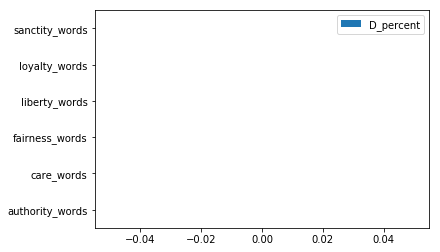

In [37]:
avg_dem_stats.plot.barh()

Take a look at this graph. What does it show? How does it compare with the predictions of MFT?


WRITE ANSWER HERE

### Republicans <a id='subsection 6'></a>

Now, let's repeat the process for Republicans. Replace the ellipses with the correct code to select only Republican speeches, then run the cell to create the table. 

(Hint: look back at how we made the 'democrats' table to see how to fill in the ellipses)

In [38]:
# Filter out non-Republican speeches
... 

# select 'Party' column from 'speeches'
party_col = speeches['Party']

# create a condition (boolean expression) that checks if a party is Republican
republican_cond = party_col == 'R'

# index `speeches` using `republican_cond`
republicans = speeches[republican_cond]

# uncomment the next line to show the first 5 rows of the `republican` DataFrame
republicans.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words,authority_words,care_words,fairness_words,liberty_words,loyalty_words,sanctity_words
0,Jeb Bush,R,c,2015-06-15,Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,...",2284,0.0,0.0,0.0,0.0,0.0,0.0
1,Jeb Bush,R,c,2015-07-30,Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y...",2638,0.0,0.0,0.0,0.0,0.0,0.0
2,Jeb Bush,R,c,2015-08-11,Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ...",3735,0.0,0.0,0.0,0.0,0.0,0.0
3,Jeb Bush,R,c,2015-09-09,"Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ...",1880,0.0,0.0,0.0,0.0,0.0,0.0
4,Jeb Bush,R,c,2015-11-02,"Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ...",2550,0.0,0.0,0.0,0.0,0.0,0.0


Then, calculate the averages.

In [39]:
# select the foundations columns and calculate the mean percent for each
avg_rep_stats = (republicans.loc[:, list(mft_dict.keys())]
                 .apply(np.mean)
                 .to_frame('R_percent'))

avg_rep_stats 

,R_percent
authority_words,0.0
care_words,0.0
fairness_words,0.0
liberty_words,0.0
loyalty_words,0.0
sanctity_words,0.0


Finally, create a bar plot of `avg_rep_stats` using the `.plot.barh()` method.

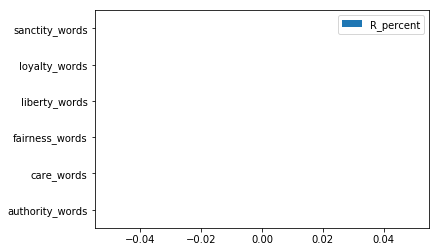

In [40]:
# your code here
avg_rep_stats.plot.barh()
plt.show()

How does this plot compare with Moral Foundations Theory predictions?

WRITE ANSWER HERE

### Democrats vs Republicans <a id='subsection 7'></a>

Comparing two groups becomes much easier when they are plotted on the same graph. 

First, combine `avg_dem_stats` and `avg_rep_stats` into one DataFrame with the `join` function. `join` is called on one table using `.join()`, takes the other table as its argument (in the parentheses), and returns a table with the indices matched. 

Now, write the code to join `avg_dem_stats` with `avg_rep_stats`.

In [41]:
# fill in the ellipses with your code
all_avg_stats = avg_dem_stats.join(avg_rep_stats)
all_avg_stats

,D_percent,R_percent
authority_words,0.0,0.0
care_words,0.0,0.0
fairness_words,0.0,0.0
liberty_words,0.0,0.0
loyalty_words,0.0,0.0
sanctity_words,0.0,0.0


Then, make a horizontal bar plot for `all_avg_stats'.

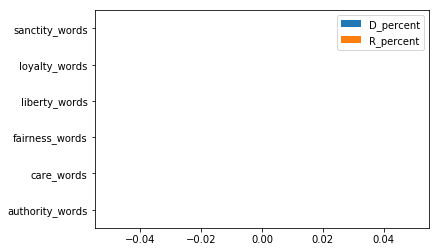

In [42]:
# your code here
all_avg_stats.plot.barh()
plt.show()


It can be hard to make comparison judgments if the bar lengsth are very similar. The next cell creates a plot of only the difference in average foundation word usage of Democrats and Republicans. A positive value means Democrats use the word more frequently; a negative value indicates Republicans use it more frequently.

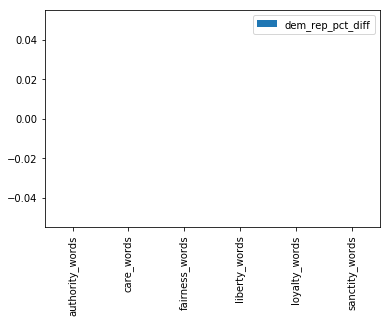

In [43]:
# uncomment the next two lines to plot the difference in percent of foundations words per speech by party
party_diffs = pd.DataFrame(data = avg_dem_stats['D_percent'] - avg_rep_stats['R_percent'],
                          columns = ["dem_rep_pct_diff"], 
                          index = mft_dict.keys())
party_diffs.plot.bar()
plt.show()

Interpret this plot above, what do you see?

WRITE ANSWER HERE

---
## Part 3: Additional Visualizations<a id='section 3'></a>

Many different graphs can be generated from the same data set to facilitate different comparisons. For example, we can compare the average use of foundation words by individual Democrats...

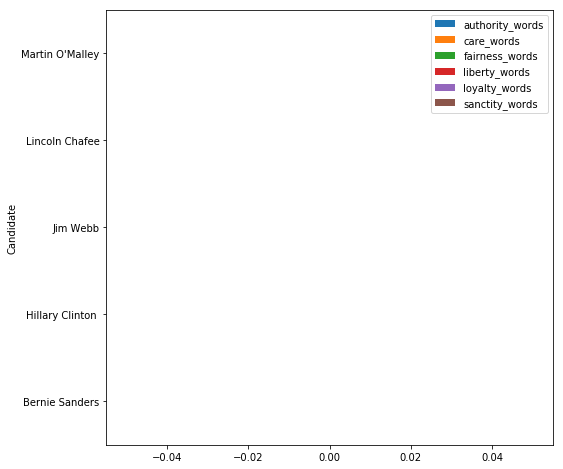

In [44]:
dem_indivs = (democrats.loc[:, list(mft_dict.keys()) + ['Candidate']]
             .groupby('Candidate')
             .mean())

dem_indivs.plot.barh(figsize=(8, 8))
plt.show()

...or individual Republicans.

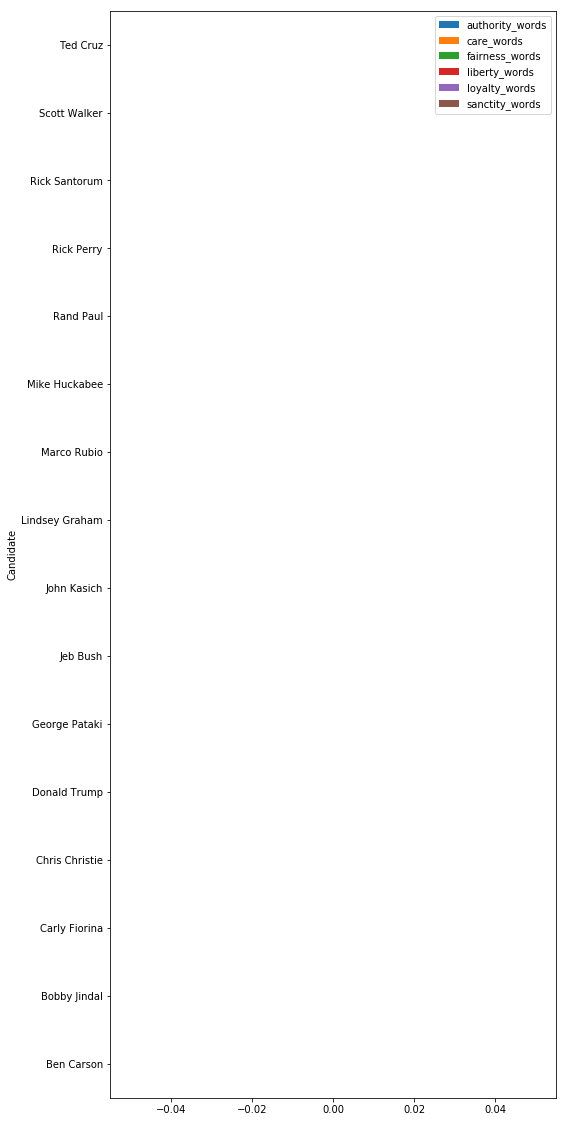

In [45]:
rep_indivs = (republicans.loc[:, list(mft_dict.keys()) + ['Candidate']]
             .groupby('Candidate')
             .mean())

rep_indivs.plot.barh(figsize=(8, 20))
plt.show()

We can also examine how a candidate uses foundation words over time. The following plot shows foundation word usage for Donald Trump in the weeks leading up to the election.

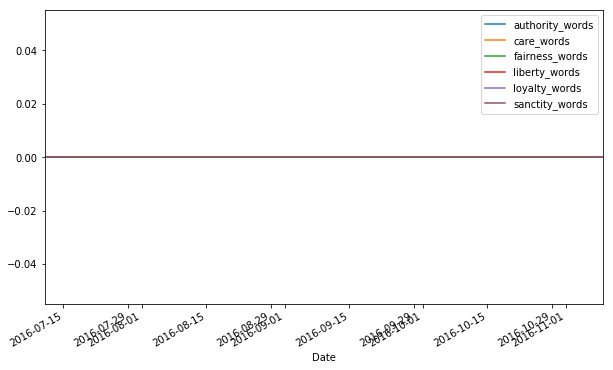

In [46]:
# select Trump's speeches and drop unnecessary columns
trump = (republicans[republicans['Candidate'] == "Donald Trump"]
         .loc[:, list(mft_dict.keys()) + ['Date']])

# set the speech dates as the table index
trump['Date'] = pd.to_datetime(trump['Date'])
trump = (trump.set_index('Date')
         .loc['2016-07-01':])

# plot the data
trump.plot(figsize = (10, 6))
plt.show()

What other kinds of plots could be generated from this data? What other questions might we be able to explore with these or other plots?

WRITE ANSWER HERE

---
## Part 4: Dictionary Comparisons <a id='section 4'></a>

Compare the results you had with your own hand-coded dictionaries to that of your classmates and answer the following. 

1. How are these graphs different from the ones made by your classmates? 
2. How are these graphs different from the ones made using the Wordnet dictionary?
3. Do your graphs support the Moral Foundations Theory?

WRITE ANSWER HERE

## Dinosaur Data <a id='subsection 8'></a>

Let's now switch over to a different data set to demonstrate the importance of creating graphs and data visualization in general. While charts are often just looked upon as pretty pictures, there are lots of important information that can be gathered. We will explore **Anscombe's Quartet**, as a tool for demonstrating this fact. First, let's take a look at these two visualizations below.

<img src="Star.png">
<img src="Dino.png">

What are some similarities and differences that you notice between the Star and Dino visualizations?

WRITE ANSWER HERE

As it turns out, both the dinosaur and star visualizations (among many others) have the exact same summary statistics, such as x mean, y mean, x standard deviation, y standard deviation, and correlation, to two decimal places. But as you may have noticed, they look completely different in appearance.

<img src="AllDinosGrey_1.png">

Looking at the following picture, we can see how the smaller digits of the summary statistics are changing and the data points change as well.

![DinoGif](DinoSequentialSmaller.gif)


It is relatively easy to take an existing dataset, modify it slightly, and maintain those statistical properties. This is proof that we need to plot the data and never trust just the statistics tables alone! Data can be misleading otherwise.


Now, take a look at the following diagrams, where we see boxplots and violin plots (which are two different ways of showing data). What are some similarities and differences you notice between these? 

Based on what you know about both types of plots, which seems like the better one for visualizing data?

<img src="BoxViolin.png">

Based on the following gif below, we can see that as our data is changing, our boxplots may not change, while our violin plots are changing. Violin plots in general are a good way to present a data set with more information as compared to a boxplot. 

![ViolinGif](BoxViolinSmaller.gif)


In general, with any visualization we use, we want to make sure that the underlying data is portrayed in a way so important information is not hidden.

---

## Bibliography

* Election documents scraped from http://www.presidency.ucsb.edu/2016_election.php
* Graham, J., Haidt, J., & Nosek, B. A. (2009). Liberals and conservatives rely on different sets of moral foundations. Journal of personality and social psychology, 96(5), 1029. http://projectimplicit.net/nosek/papers/GHN2009.pdf, October 9 2017.
* Anscombe's Quartet Data from https://www.autodeskresearch.com/publications/samestats

---
Current notebook developed by: Alec Kan, Shalini Kunapuli, William McEachen

Previous versions of this notebook developed by: Keeley Takimoto, Sean Seungwoo Son, Sujude Dalieh

Data Science Modules: http://data.berkeley.edu/education/modules
